# Product 620 

The products in this dataset are categorized under the `Product_Code` feature. The product for analysis in this notebook is product 620. I used ARIMA and linear regression to perform time series forecasting for product 620. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('data_formatted.csv')

In [3]:
_620 = data.loc[(data['prod_code'] == 620)]

In [4]:
_620.head(5)

,Unnamed: 0,Date,Order_Demand,year,month,day,prod_code,warehouse,category
1858,1858,2012-02-01,1,2012.0,2.0,1.0,620,J,1
1861,1861,2012-01-20,3,2012.0,1.0,20.0,620,J,1
1864,1864,2012-01-26,2,2012.0,1.0,26.0,620,J,1
1865,1865,2012-02-01,4,2012.0,2.0,1.0,620,J,1
1871,1871,2012-01-20,2,2012.0,1.0,20.0,620,J,1


In [5]:
_620['category'].value_counts()

category
1    9428
Name: count, dtype: int64

The `category` and `prod_code` are the same for both columns. 

In [6]:
_620 = _620.drop(columns =['Unnamed: 0', 'warehouse', 'category', 'prod_code'])

In [7]:
_620.set_index('Date')

,Order_Demand,year,month,day
Date,,,,
2012-02-01,1,2012.0,2.0,1.0
2012-01-20,3,2012.0,1.0,20.0
2012-01-26,2,2012.0,1.0,26.0
2012-02-01,4,2012.0,2.0,1.0
2012-01-20,2,2012.0,1.0,20.0
...,...,...,...,...
2016-10-17,1,2016.0,10.0,17.0
2016-12-06,1,2016.0,12.0,6.0
2016-12-08,1,2016.0,12.0,8.0


<Axes: >

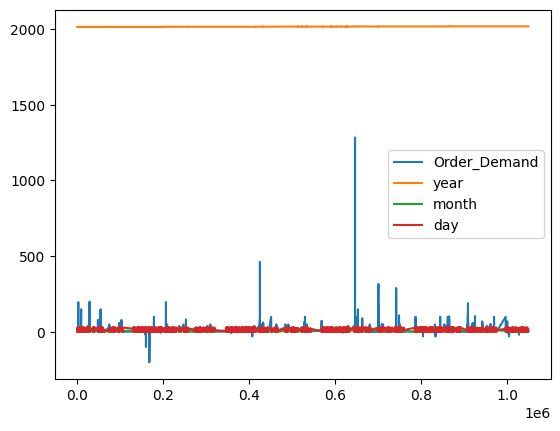

In [8]:
_620.plot()

There are some negative values. I realized there could be multiple orders on a specific day. So, I needed to take the sum of all the orders on a particular day. 

In [9]:
aggregation_functions = {'Order_Demand':'sum', 'year':'first', 'month':'first', 'day':'first'}
prod620 = _620.groupby(_620['Date']).aggregate(aggregation_functions)
prod620.index.name = None
withdates_620 = prod620

<Axes: >

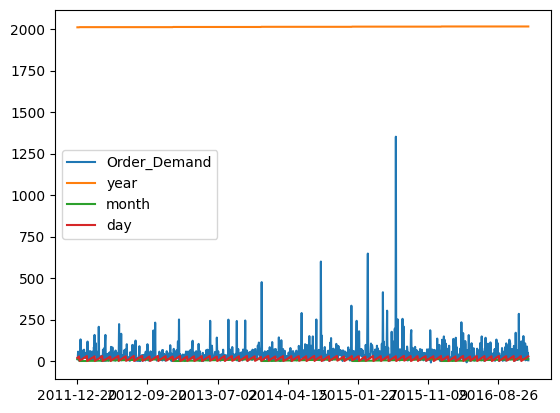

In [10]:
prod620.plot()

From this plot, there isn't a clear trend. It seems like there are spikes, but it is hard to see the correlation as to when those spikes occur. 

array([[<Axes: title={'center': 'Order_Demand'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>]], dtype=object)

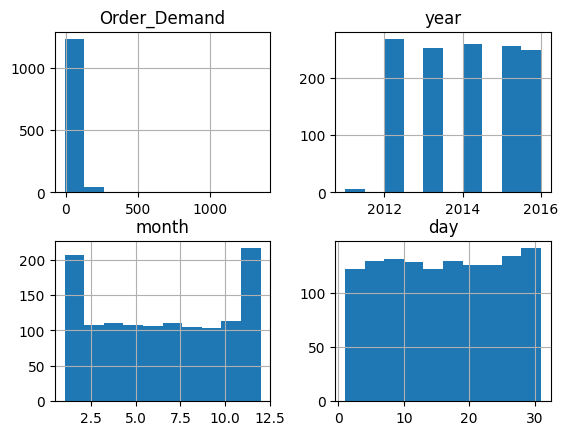

In [11]:
prod620.hist()

It looks like there is no data from before 2012. It also looks like the majority of sales are in month 1 and month 12. So, it must be a seasonal item for December and January. Maybe a scarf or a coat? It also looks like the most popular amount to order is close to 1,400 items. The day appears to have no impact. 

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import datetime
from matplotlib import pyplot

In [13]:
prod620 = prod620.drop(columns =['day', 'month', 'year'])

# ARIMA

I learned about the ARIMA model here https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In order to fit and predict the data correctly, I needed to split the data into a train and test group. I used the first 2/3 of the data for training and the last 1/3 for testing. 

The parameters in the ARIMA model are set to 2,2 and 0 for the lag value, difference order, and moving average, respectively. I choose 2 for the order differencing because there isn't a trend over time. It looks like there is only a seasonal trend.

In [14]:
model = ARIMA(prod620, order=(2,2,0))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
model_fit = model.fit()

In [16]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                 1288
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -7683.589
Date:                Mon, 01 Jan 2024   AIC                          15373.178
Time:                        09:34:54   BIC                          15388.656
Sample:                             0   HQIC                         15378.989
                               - 1288                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9917      0.005   -217.945      0.000      -1.001      -0.983
ar.L2         -0.5321      0.008    -68.086      0.000      -0.547      -0.517
sigma2      9064.7263     77.235    117.365      0.0

I passed the order values 5,1,0 which means 5 is the lag value, the difference order is 1 becuase I wanted a stationary series, and 0 is the moving average. 

The `predict()` function is used to predict sales for future times. Since I was forecasting based on time, I had to be careful on how I split the training and testing group. So, I fed the training group into the model and used the testing group to generate a predicition. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


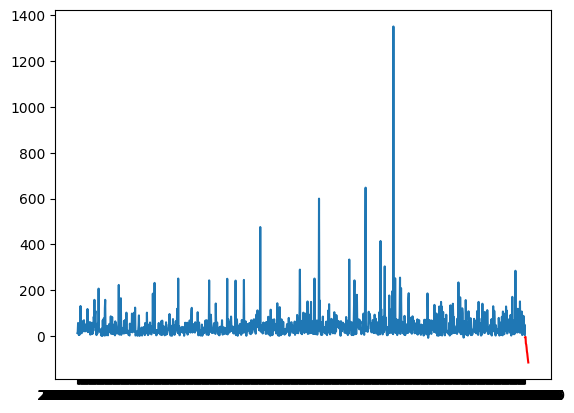

In [17]:
forecast = model_fit.get_forecast(steps=10) 
plt.plot(prod620, label='Observed')
plt.plot(forecast.predicted_mean, color='red', label='Forecast')
plt.show()

Now we forecast. 

In [18]:
#X = x_620.values
X = prod620
size = int(len(X) * 0.66)
train = X.iloc[:len(X)-12]
test = X.iloc[len(X)-12:]

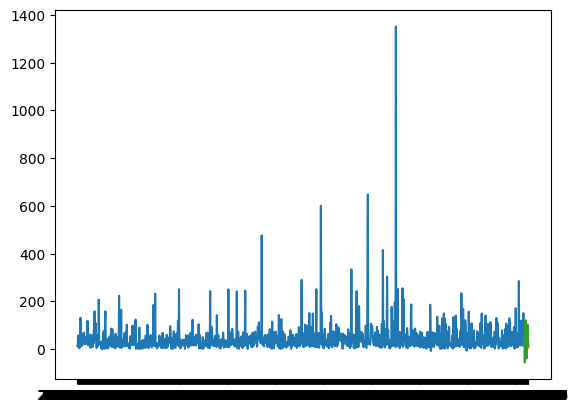

In [19]:
forecast = model_fit.predict(start = len(train), end=len(train)+len(test)-1, typ = 'levels').rename("Predictions") 

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicition')


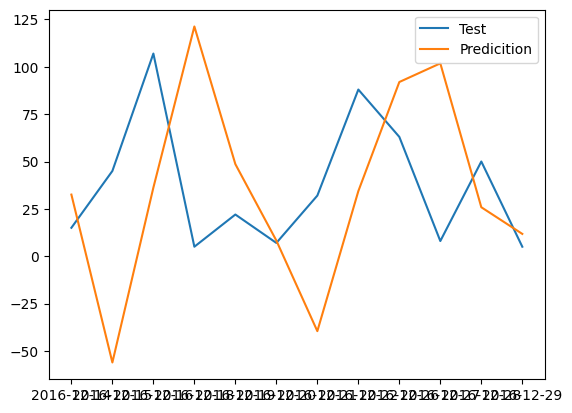

In [20]:
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicition')
plt.legend(loc='best')
#plt.show()

By zooming in on the predictions, we see that the test values (actual order demand) and the predictions don't match great. This means the model isn't very accurate. 

# Trying Again

This time, used 1 as the difference order.  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


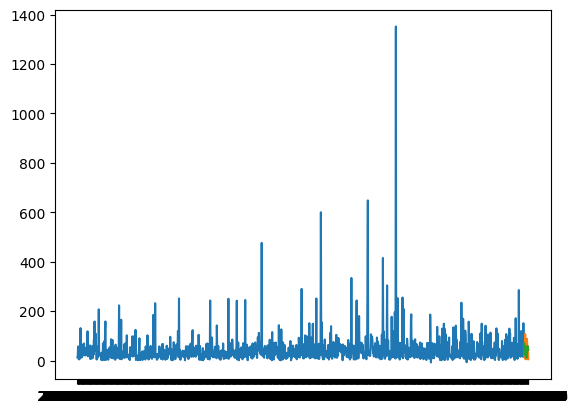

In [21]:
model2 = ARIMA(prod620, order=(2,1,0))
model_fit = model2.fit()

forecast = model_fit.predict(start = len(train), end=len(train)+len(test)-1, typ = 'levels').rename("Predictions") 

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicition')

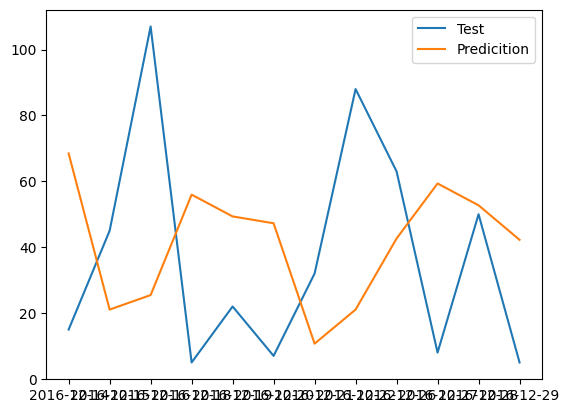

In [22]:
plt.plot(test, label='Test')
plt.plot(forecast, label='Predicition')
plt.legend(loc='best')

The model still doesn't fit great. Next time I would try by changing the lag value or use a model that incorperates seasonality. I could also use differencing to better fit the data. 

# Linear Regression 

The second model I tried was linear regression. 

In [23]:
from sklearn.linear_model import LinearRegression

Using linear regression, I wanted to predict the sales using the month. 

We still must make a training set and a testing set. I split the data up into thirds and the first 2/3 were training and the last 1/3 was testing. 

In [24]:
x_620 = withdates_620.drop(columns=['Order_Demand'])
X = x_620.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [25]:
y = withdates_620.Order_Demand
size = int(len(y) * 0.66)
ytrain, ytest = y[0:size], y[size:len(X)]

In [26]:
model = LinearRegression()

In [27]:
model.fit(train, ytrain)

LinearRegression()

In [28]:
r_sq = model.score(test, ytest)
print('coefficient of determination:', r_sq)

coefficient of determination: -0.027614685439295572


Terrible coefficient of determination. 

## Forecasting

However, we can still use the model to make predicitions and forecast future sales. So, if you want to predict the demand for the first of april, 2016 then you can feed that into the model. 

In [29]:
pred = [[2016, 4, 1]]

In [30]:
[[2016, 4, 1]]

[[2016, 4, 1]]

In [31]:
pred_demand = model.predict(pred)
print(pred_demand)

[64.02393193]


In [32]:
pred = [[2018, 1, 1]]
pred_demand = model.predict(pred)
print(pred_demand)

[79.44941998]
